In [1]:
import os, sys, h5py
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score

# plotting tools
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

np.random.seed(33) # for reproducibility

In [2]:

        
def interpretability_performance(X, score, X_model, buffer=20):

    pr_score = []
    roc_score = []
    for j, gs in enumerate(score):

        # calculate information of ground truth
        gt_info = np.log2(4) + np.sum(X_model[j]*np.log2(X_model[j]+1e-10),axis=0)

        # set label if information is greater than 0
        label = np.zeros(gt_info.shape)
        label[gt_info > 0.01] = 1
        
        # extend labels
        box_filter = np.ones(buffer)
        pad_left = int(buffer/2)
        pad_right = buffer - pad_left
        x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
        new_label = []
        for n in range(L):
            new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
        new_label = np.array(new_label)
        new_label[new_label > 0.01] = 1

        # get positive instance 
        pos_instance = []
        index = 0
        status = True
        while status:
            s = np.where(new_label[index:] == 1)[0]
            if any(list(s)):
                start = index + s[0]
            else:
                status = False
            e = np.where(new_label[index+start:] == 0)[0]
            if any(list(e)):
                end = index + start + e[0]
                pos_instance.append(np.max(gs[start:end]))
                index = end
            else:
                status = False
        
        # get negative instance
        neg_instance = []
        index = 0
        status = True
        while status:
            s = np.where(new_label[index:] == 0)[0]
            if any(list(s)):
                start = index + s[0]
            else:
                status = False
            e = np.where(new_label[index+start:] == 1)[0]
            if any(list(e)):
                end = index + start + e[0]
                neg_instance.append(np.max(gs[start:end]))
                index = end
            else:
                end = L
                neg_instance.append(np.max(gs[start:end]))
                status = False

        vals = np.concatenate([pos_instance, neg_instance])
        labels = np.concatenate([np.ones(len(pos_instance)), np.zeros(len(neg_instance))])

        # precision recall metric
        precision, recall, thresholds = precision_recall_curve(labels, vals)
        pr_score.append(auc(recall, precision))

        # roc curve
        fpr, tpr, thresholds = roc_curve(labels, vals)
        roc_score.append(auc(fpr, tpr))

    roc_score = np.array(roc_score)
    pr_score = np.array(pr_score)

    return roc_score, pr_score
    

In [3]:
import helper 

# load data
data_path = '../data/synthetic_dataset.h5'
data = helper.load_dataset(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = helper.load_synthetic_models(data_path, dataset='test')
#true_index = np.where(y_test[:,0] == 1)[0]
X = x_test#[true_index]
X_model = test_model#[true_index]
print(X.shape)

(6000, 200, 4)


## Get ground truth motifs from JASPAR database

In [4]:
def get_jaspar_motifs(file_path):
    def get_motif(f):
        line = f.readline()
        name = line.strip().split()[1]
        pfm = []
        for i in range(4):
            line = f.readline()
            if len(line.split()[1]) > 1:
                pfm.append(np.asarray(np.hstack([line.split()[1][1:], line.split()[2:-1]]), dtype=float))
            else:
                pfm.append(np.asarray(line.split()[2:-1], dtype=float))
        pfm = np.vstack(pfm)
        sum_pfm = np.sum(pfm, axis=0)
        pwm = pfm/np.outer(np.ones(4), sum_pfm)
        line = f.readline()
        return name, pwm

    num_lines = sum(1 for line in open(file_path))
    num_motifs = int(num_lines/6)

    f = open(file_path)
    tf_names = []
    tf_motifs = []
    for i in range(num_motifs):
        name, pwm = get_motif(f)
        tf_names.append(name)
        tf_motifs.append(pwm)

    return tf_motifs, tf_names

# parse JASPAR motifs
savepath = '../data'
file_path = os.path.join(savepath, 'pfm_vertebrates.txt')
motif_set, motif_names = get_jaspar_motifs(file_path)

# get a subset of core motifs 
#core_names = ['SP1', 'Gabpa', 'CEBPB', 'MAX', 'YY1']
core_names = ['Arid3a', 'CEBPB', 'FOSL1', 'Gabpa', 'MAFK', 'MAX', 
              'MEF2A', 'NFYB', 'SP1', 'SRF', 'STAT1', 'YY1']
strand_motifs = []
core_index = []
for name in core_names:
    strand_motifs.append(motif_set[motif_names.index(name)])
    core_index.append(motif_names.index(name))

# generate reverse compliments
core_motifs = []
for pwm in strand_motifs:
    core_motifs.append(pwm)
    reverse = pwm[:,::-1]
    core_motifs.append(reverse[::-1,:]) 


In [5]:
N, L, A = X.shape
num_motifs = len(core_motifs)

fmap_all = []
for n, x in enumerate(X):
    if np.mod(n+1,250) == 0:
        print("%d out of %d"%(n+1, N))
    fmap_motifs = []
    for i in range(num_motifs):
        pwm = core_motifs[i]
        pwm = pwm.T
        M = pwm.shape[0]
        
        num_pad = M
        pad_left = int(num_pad/2)
        pad_right = num_pad - pad_left
        x_pad = np.concatenate([np.zeros((pad_left, 4)), x, np.zeros((pad_right,4))], axis=0) 
        fmap = []
        for n in range(L):
            fmap.append(np.sum(x_pad[range(n,n+M),:] * pwm))            
        fmap_motifs.append(fmap)
        
    fmap_all.append(fmap_motifs)
fmap_all = np.array(fmap_all)

250 out of 6000
500 out of 6000
750 out of 6000
1000 out of 6000
1250 out of 6000
1500 out of 6000
1750 out of 6000


KeyboardInterrupt: 

In [ ]:
N, L, A = X.shape
num_motifs = len(core_motifs)

fmap_pwm = []
for n, x in enumerate(X):
    if np.mod(n+1,250) == 0:
        print("%d out of %d"%(n+1, N))
    fmap_motifs = []
    for i in range(num_motifs):
        pwm = np.log2(core_motifs[i]/(np.ones(core_motifs[i].shape)/4)+1e-10)
        pwm = pwm.T
        M = pwm.shape[0]
        
        num_pad = M
        pad_left = int(num_pad/2)
        pad_right = num_pad - pad_left
        x_pad = np.concatenate([np.zeros((pad_left, 4)), x, np.zeros((pad_right,4))], axis=0) 
        fmap = []
        for n in range(L):
            fmap.append(np.sum(x_pad[range(n,n+M),:] * pwm))            
        fmap_motifs.append(fmap)
        
    fmap_pwm.append(fmap_motifs)
fmap_pwm = np.array(fmap_pwm)
    

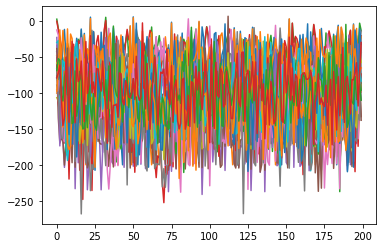

In [6]:
index = 0
plt.plot(fmap_all[index].T);
#plt.plot(score2[index])

In [ ]:
score = np.max(fmap_all, axis=1)
roc_score, pr_score = interpretability_performance(X, score, X_model, buffer=5)
print(np.nanmean(roc_score), np.nanstd(roc_score))
print(np.nanmean(pr_score), np.nanstd(pr_score))

In [ ]:
score = np.max(fmap_all, axis=1)
roc_score, pr_score = interpretability_performance(X, score, X_model, buffer=10)
print(np.nanmean(roc_score), np.nanstd(roc_score))
print(np.nanmean(pr_score), np.nanstd(pr_score))

In [ ]:
from six.moves import cPickle
with open('pwm_scans.pickle', 'wb') as f:
    cPickle.dump(roc_score, f)
    cPickle.dump(pr_score, f)
    

# get fmaps

In [8]:
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
from tensorflow import keras
import helper
from tfomics import utils, metrics

#------------------------------------------------------------------------

num_trials = 10
model_names = ['cnn-deep']# deep', 'cnn-25', 'cnn-4'] #
activations = ['exponential', 'relu']

results_path = utils.make_directory('../results', 'synthetic')
params_path = utils.make_directory(results_path, 'model_params')

#------------------------------------------------------------------------
results = {}
for model_name in model_names:
    for activation in activations:
        results[model_name+'_'+activation] = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model, name = helper.load_model(model_name, 
                                            activation=activation, 
                                            dropout=True, 
                                            l2=1e-6, 
                                            bn=True,
                                            input_shape=200)
            base_name = name+'_'+activation
            name = base_name+'_'+str(trial)
            print('model: ' + name)

            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)            
            
            intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[3].output)
            results[model_name+'_'+activation].append(intermediate.predict(X))
        

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


model: cnn-deep_do_l2_bn_exponential_0
model: cnn-deep_do_l2_bn_exponential_1
model: cnn-deep_do_l2_bn_exponential_2
model: cnn-deep_do_l2_bn_exponential_3
model: cnn-deep_do_l2_bn_exponential_4
model: cnn-deep_do_l2_bn_exponential_5
model: cnn-deep_do_l2_bn_exponential_6
model: cnn-deep_do_l2_bn_exponential_7
model: cnn-deep_do_l2_bn_exponential_8
model: cnn-deep_do_l2_bn_exponential_9
model: cnn-deep_do_l2_bn_relu_0
model: cnn-deep_do_l2_bn_relu_1
model: cnn-deep_do_l2_bn_relu_2
model: cnn-deep_do_l2_bn_relu_3
model: cnn-deep_do_l2_bn_relu_4
model: cnn-deep_do_l2_bn_relu_5
model: cnn-deep_do_l2_bn_relu_6
model: cnn-deep_do_l2_bn_relu_7
model: cnn-deep_do_l2_bn_relu_8
model: cnn-deep_do_l2_bn_relu_9


In [ ]:
# save results
file_path = os.path.join(results_path, 'fmaps.pickle')
with open(file_path, 'wb') as f:
    cPickle.dump(results, f, protocol=cPickle.HIGHEST_PROTOCOL)

In [37]:
for i in range(num_trials):
    score2 = np.max(results['cnn-deep_exponential'][i], axis=2)
    roc_score2, pr_score2 = interpretability_performance(X, score2, X_model, buffer=10)
    print('trial '+str(i))
    print(np.nanmean(roc_score2), np.nanstd(pr_score2))
    print(np.nanmean(pr_score2), np.nanstd(pr_score2))    
    

trial 0
0.8768997017151381 0.2630045655510873
0.8426962155108129 0.2630045655510873
trial 1
0.8822431953765846 0.2600871843452729
0.8478317253914989 0.2600871843452729
trial 2
0.8745406879194632 0.26635038084377244
0.8394677479492916 0.26635038084377244
trial 3
0.8739774422073079 0.2662516704716999
0.8387458053691276 0.2662516704716999
trial 4
0.8792556860551827 0.26151141865499
0.8448531879194631 0.26151141865499
trial 5
0.8718328206562267 0.2667471790329088
0.838469658836689 0.2667471790329088
trial 6
0.8666608407904549 0.2700393097699854
0.8345297352721848 0.2700393097699854
trial 7
0.8747359712900821 0.2652712290024346
0.8402063358900607 0.2652712290024346
trial 8
0.8730278243847877 0.266226953161057
0.8389721822733567 0.266226953161057
trial 9
0.8743141778523491 0.26620972493566536
0.8383787751677853 0.26620972493566536


In [42]:
best_index = 1
fmap_deep_exp = results['cnn-deep_exponential'][best_index]
score2 = np.max(fmap_deep_exp, axis=2)

for buffer in [5,10, 15, 20]:
    roc_score_deep_exp, pr_score_deep_exp = interpretability_performance(X, score2, X_model, buffer=buffer)
    print(buffer)
    print(np.nanmean(roc_score_deep_exp), np.nanstd(roc_score_deep_exp))
    print(np.nanmean(pr_score_deep_exp), np.nanstd(pr_score_deep_exp))    

5
0.8581053726298588 0.2344543330517414
0.8302756454133272 0.2708039922249375
10
0.8822431953765846 0.20300052173328179
0.8478317253914989 0.2600871843452729
15
0.8892525397092665 0.20052947211080166
0.8563637724270827 0.2563717312557046
20
0.896398017956971 0.19645899466550013
0.8635420784158714 0.254904982065556


In [43]:
score = np.max(fmap_all, axis=1)
for buffer in [5,10, 15, 20]:
    roc_score, pr_score = interpretability_performance(X, score, X_model, buffer=buffer)
    print(buffer)
    print(np.nanmean(roc_score), np.nanstd(roc_score))
    print(np.nanmean(pr_score), np.nanstd(pr_score))    

5
0.6474111835385444 0.34276704509057987
0.6342828158618732 0.33060356402379354
10
0.6666659675615212 0.3371511297280427
0.6475868554916374 0.3314740249989067
15
0.6832893678322202 0.33518216753064145
0.6629111242072179 0.3322619009306454
20
0.7026429593238842 0.3309805779075808
0.6790737289890263 0.33331272492725467


In [9]:
best_index = 1
fmap_deep_exp = results['cnn-deep_exponential'][best_index]
score2 = np.max(fmap_deep_exp, axis=2)
score = np.max(fmap_all, axis=1)
roc_score_deep_exp, pr_score_deep_exp = interpretability_performance(X, score2, X_model, buffer=10)    
roc_score, pr_score = interpretability_performance(X, score, X_model, buffer=10)


/home/peter/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/peter/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [10]:
best_index = 1
fmap_deep_relu = results['cnn-deep_relu'][best_index]
score3 = np.max(fmap_deep_relu, axis=2)

roc_score, pr_score = interpretability_performance(X, score3, X_model, buffer=10)   
print(np.nanmean(roc_score), np.nanstd(roc_score))
print(np.nanmean(pr_score), np.nanstd(pr_score))     

0.391400307606264 0.33118645487011755
0.41538980105464995 0.27702151789488977


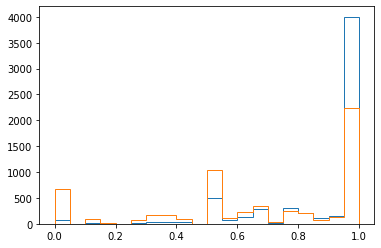

In [53]:
plt.figure()
N, edges, _ = plt.hist(roc_score_deep_exp, bins=20, histtype='step')
N2, edges2, _ = plt.hist(roc_score, bins=20, histtype='step')



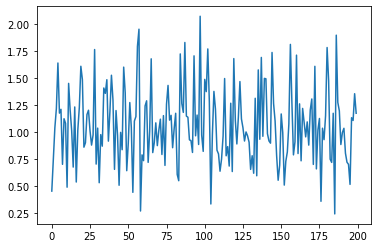

In [88]:
plt.plot(score3[7].T);

# log scans

In [47]:
keras.backend.clear_session()

import task2_cnn_deep_log

# load model
model = task2_cnn_deep_log.model('log_relu', True)

name = 'cnn-deep_log_relu_l2_0'
weights_path = os.path.join('../results/synthetic_code_log/model_params', name+'.hdf5')
model.load_weights(weights_path)


intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[3].output)
fmap_deep_log = intermediate.predict(X)


[]

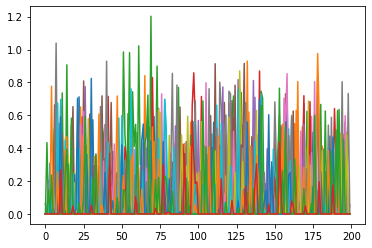

In [51]:

plt.plot(np.maximum(fmap_deep_log[index], 0));
ax.set_xticklabels([])

# Plot scan comparison

In [11]:
from tfomics import utils
plot_path = utils.make_directory(results_path, 'pwm_comparison_new')

making directory: ../results/synthetic/pwm_comparison_new


([], <a list of 0 Text yticklabel objects>)

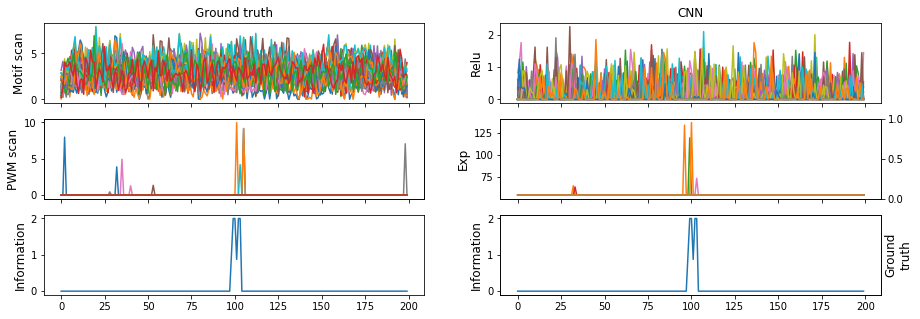

In [20]:
index = 10
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(3,2,1)
ax.plot(np.maximum(fmap_all[index].T, 0));
ax.set_xticklabels([])
plt.title('Ground truth', fontsize=12)
plt.ylabel('Motif scan', fontsize=12)
#plt.figure()
#plt.plot(fmap_deep_relu[index]);

ax = plt.subplot(3,2,2)

threshold = np.exp(-10)
ax.plot(np.maximum(fmap_deep_relu[index], threshold));
ax.set_xticklabels([])
plt.title('CNN', fontsize=12)
plt.ylabel('Relu', fontsize=12)


ax = plt.subplot(3,2,3)
ax.plot(np.maximum(fmap_pwm[index].T, 0));
plt.ylabel('PWM scan', fontsize=12)
ax.set_xticklabels([])
ax2 = ax.twinx()
#plt.ylabel('PWM', fontsize=12)
plt.yticks([])

ax = plt.subplot(3,2,4)
threshold = np.exp(4)
ax.plot(np.maximum(fmap_deep_exp[index], threshold));
ax.set_xticklabels([])
plt.ylabel('Exp', fontsize=12)
ax2 = ax.twinx()


ax = plt.subplot(3,2,5)
buffer = 1

# calculate information of ground truth
gt_info = np.log2(4) + np.sum(X_model[index]*np.log2(X_model[index]+1e-10),axis=0)

# set label if information is greater than 0
label = np.zeros(gt_info.shape)
label[gt_info > 0.01] = 1

# extend labels
box_filter = np.ones(buffer)
pad_left = int(buffer/2)
pad_right = buffer - pad_left
x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
new_label = []
for n in range(L):
    new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
new_label = np.array(new_label)
new_label[new_label > 0.01] = 1
plt.ylabel('Information', fontsize=12)

ax.plot(gt_info);

ax = plt.subplot(3,2,6)
buffer = 1

# calculate information of ground truth
gt_info = np.log2(4) + np.sum(X_model[index]*np.log2(X_model[index]+1e-10),axis=0)

# set label if information is greater than 0
label = np.zeros(gt_info.shape)
label[gt_info > 0.01] = 1

# extend labels
box_filter = np.ones(buffer)
pad_left = int(buffer/2)
pad_right = buffer - pad_left
x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
new_label = []
for n in range(L):
    new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
new_label = np.array(new_label)
new_label[new_label > 0.01] = 1
plt.ylabel('Information', fontsize=12)

ax.plot(gt_info);
ax2 = ax.twinx()
plt.ylabel('Ground\ntruth', fontsize=12)
plt.yticks([])


In [32]:
indices = np.where(np.sum(y_test, axis=1) == 2)[0]

In [33]:
plot_path = utils.make_directory(results_path, 'pwm_scan_new2')

for index in indices[:100]:#range(50,100):

    fig = plt.figure(figsize=(15,5))


    ax = plt.subplot(3,2,1)
    ax.plot(np.maximum(fmap_all[index].T, 0));
    ax.set_xticklabels([])
    plt.title('Ground truth', fontsize=12)
    plt.ylabel('Motif scan', fontsize=12)
    #plt.figure()
    #plt.plot(fmap_deep_relu[index]);

    ax = plt.subplot(3,2,2)
    ax.plot(fmap_deep_relu[index]);
    ax.set_xticklabels([])
    plt.title('CNN', fontsize=12)
    plt.ylabel('Relu', fontsize=12)


    ax = plt.subplot(3,2,3)
    ax.plot(np.maximum(fmap_pwm[index].T, 0));
    plt.ylabel('PWM scan', fontsize=12)
    ax.set_xticklabels([])

    ax = plt.subplot(3,2,4)
    threshold = np.exp(4)
    ax.plot(fmap_deep_exp[index]);
    ax.set_xticklabels([])
    plt.ylabel('Exp', fontsize=12)


    ax = plt.subplot(3,2,5)
    buffer = 1

    # calculate information of ground truth
    gt_info = np.log2(4) + np.sum(X_model[index]*np.log2(X_model[index]+1e-10),axis=0)

    # set label if information is greater than 0
    label = np.zeros(gt_info.shape)
    label[gt_info > 0.01] = 1

    # extend labels
    box_filter = np.ones(buffer)
    pad_left = int(buffer/2)
    pad_right = buffer - pad_left
    x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
    new_label = []
    for n in range(L):
        new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
    new_label = np.array(new_label)
    new_label[new_label > 0.01] = 1
    plt.ylabel('Information', fontsize=12)

    plt.xlabel('Position', fontsize=12)
    ax.plot(gt_info);

    ax = plt.subplot(3,2,6)
    buffer = 1

    # calculate information of ground truth
    gt_info = np.log2(4) + np.sum(X_model[index]*np.log2(X_model[index]+1e-10),axis=0)

    # set label if information is greater than 0
    label = np.zeros(gt_info.shape)
    label[gt_info > 0.01] = 1

    # extend labels
    box_filter = np.ones(buffer)
    pad_left = int(buffer/2)
    pad_right = buffer - pad_left
    x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
    new_label = []
    for n in range(L):
        new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
    new_label = np.array(new_label)
    new_label[new_label > 0.01] = 1
    plt.ylabel('Information', fontsize=12)

    ax.plot(gt_info);
    ax2 = ax.twinx()
    plt.ylabel('Ground\ntruth', fontsize=12)
    plt.yticks([])
    plt.xlabel('Position', fontsize=12)


    outfile = os.path.join(plot_path, 'pwm_comparison_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()



making directory: ../results/synthetic/pwm_scan_new2


# Plot box plot comparison between relu vs exp vs pwm scan (give null baseline for random guessing)

In [385]:
np.log(.25)

-1.3862943611198906

# Plot scatter plot between pwm and exp aupr scores

In [420]:
from scipy import stats
pval = stats.ttest_ind(pr_score_pwm, pr_score_deep_exp).pvalue
pval

0.08258157435814215

In [419]:

pval = stats.ttest_ind(roc_score_pwm, roc_score_deep_exp).pvalue
pval

0.17788455235063427

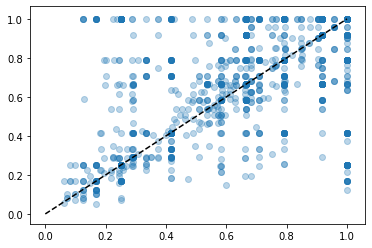

In [256]:
plt.scatter(pr_score, pr_score_deep_exp, alpha=0.3)
plt.plot([0,1], [0,1], '--k')

In [82]:

buffer = 20

pr_score = []
roc_score = []
for j, gs in enumerate(score):

    # calculate information of ground truth
    gt_info = np.log2(4) + np.sum(X_model[j]*np.log2(X_model[j]+1e-10),axis=0)

    
    # set label if information is greater than 0
    label = np.zeros(gt_info.shape)
    label[gt_info > 0.01] = 1
    
    
    # precision recall metric
    precision, recall, thresholds = precision_recall_curve(label, gs)
    pr_score.append(auc(recall, precision))

    # roc curve
    fpr, tpr, thresholds = roc_curve(label, gs)
    roc_score.append(auc(fpr, tpr))

roc_score = np.array(roc_score)
pr_score = np.array(pr_score)


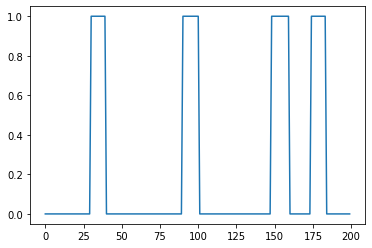

In [99]:
buffer = 10
box_filter = np.ones(buffer)
pad_left = int(buffer/2)
pad_right = buffer - pad_left
x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
new_label = []
for n in range(L):
    new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
new_label = np.array(new_label)
new_label[new_label > 0.01] = 1


In [125]:
pos_instance = []

index = 0
status = True
while status:
    s = np.where(new_label[index:] == 1)[0]
    if any(list(s)):
        start = index + s[0]
    else:
        status = False
    e = np.where(new_label[index+start:] == 0)[0]
    if any(list(e)):
        end = index + start + e[0]
        pos_instance.append(np.max(gs[start:end]))
        index = end
    else:
        status = False

pos_instance

[31.496697262260696, 32.15846118616899]

In [128]:
neg_instance = []

index = 0
status = True
while status:
    s = np.where(new_label[index:] == 0)[0]
    if any(list(s)):
        start = index + s[0]
    else:
        status = False
    e = np.where(new_label[index+start:] == 1)[0]
    if any(list(e)):
        end = index + start + e[0]
        neg_instance.append(gs[start:end])
        index = end
    else:
        status = False

neg_instance = np.concatenate(neg_instance)


In [129]:
vals = np.concatenate([pos_instance, neg_instance])
labels = np.concatenate([np.ones(len(pos_instance)), np.zeros(len(neg_instance))])
precision, recall, thresholds = precision_recall_curve(label, gs)
pr_score.append(auc(recall, precision))


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [159]:
vals

array([27.85031172, 36.35755125, 36.81160229, 18.52877196, 15.40147818,
       13.51489093, 15.03457676, 19.52557924, 20.08869056, 12.79917564,
       18.2970297 , 20.12829452, 11.73671733, 16.1033349 , 14.50856435,
       17.34196895, 13.68846744, 17.2600753 , 14.83251987, 19.72408659,
       16.79375261, 15.81543394, 15.84437317, 17.40195612, 16.9785231 ,
       16.71257305, 18.26690838, 18.31655278, 16.2958012 , 17.19120678,
       17.10300707, 20.57788314, 14.93840165, 19.82596748, 19.95099611,
       17.65053688, 14.54071568, 16.77622472, 19.12201751, 19.78749466,
       12.63868359, 13.32254916, 15.88474868, 13.49323665, 18.68481435,
       12.76912647, 23.19266626, 14.59867967, 23.15883419, 14.28420025,
       16.88300098, 19.43002617, 16.5219142 , 20.81056239, 13.66384245,
       29.48542742, 14.50453214, 14.22807419, 19.62354078, 15.0185482 ,
       14.88023815, 11.44052433, 14.6172082 , 18.30874355, 13.16803793,
       21.07488495, 20.39724443, 19.08964569, 21.83650103, 18.86

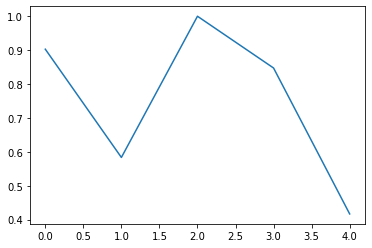

In [168]:
plt.plot(pr_score)